In [23]:
from aqua.util import load_yaml, get_arg, create_folder, dump_yaml
import pandas as pd
from scipy.stats import ks_2samp
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

machines = ["LUMI-C", "LUMI-G"]
members = ["fc0", "fc1", "fc2", "fc3","fc4", "fc5", "fc6", "fc7", "fc8", "fc9"]

    
def combine_PI_dict(ensemble_name):
    pi_score = {}
    for ensemble in ensemble_name:
        data_members= {}
        for member in members:
            # pattern = f"/scratch/project_465000454/sughosh/ecmean_files/YAML/*{machine}*/*{member}*yml"
            pattern = f"/pfs/lustrep3/scratch/project_465000454/kkeller/lab/aqua_container/replicability/out/*{ensemble}*/*/*{member}*yml"
            # print(pattern)
            # print(ensemble, member)
            yaml_files = glob.glob(pattern)
            loaded_yaml= load_yaml(yaml_files[0])
            data_members[member] = loaded_yaml
            # print(pattern)
        pi_score[ensemble] = data_members
    return pi_score

def pi_score_df(pi_score_dict):
    ensembles = []
    members = []
    variables = []
    seasons = []
    regions = []
    values = []

    for ensemble in pi_score_dict:
        for member in pi_score_dict[ensemble]:
            for variable in pi_score_dict[ensemble][member]:
                for season in pi_score_dict[ensemble][member][variable]:
                    for region in pi_score_dict[ensemble][member][variable][season]:
                        ensembles.append(ensemble)
                        members.append(member)
                        variables.append(variable)
                        seasons.append(season)
                        regions.append(region)
                        value = pi_score_dict[ensemble][member][variable][season][region]
                        values.append( value )
                        # print(machine, member, variable, season, region)
                        # if variable == "tas":
                        #     print(machine, variable, value)
                        

    # Create a DataFrame
    df = pd.DataFrame({'ensembles': ensembles, 'members': members, 'variables': variables, 'seasons': seasons, 'locations': regions, 'pi_score': values})
    return df

def categorize(value):
    if value < 0.01:
        return "p-values < 0.01"
    elif 0.01 <= value < 0.05:
        return "0.05 > p-values > 0.01"
    elif value >= 0.05:
        return "0.05 < p-values"
    elif value == np.nan:
        return None
    
def km_test_score_df(df):
    

    vars = []
    seasons = []
    regions = []
    p_values = []
    KS_score = {}

    for variable in df.variables.unique():
            for season in df.seasons.unique():
                    for location in df.locations.unique():
                            filtered_df= df[(df["variables"] == variable) & (df["seasons"] == season) & (df["locations"]== location)]
                            ensemble1= filtered_df[(filtered_df["ensembles"]==df.ensembles.unique()[0])]
                            ensemble2= filtered_df[(filtered_df["ensembles"]==df.ensembles.unique()[1])]
                            vars.append(variable)
                            seasons.append(season+"_"+location)
                            regions.append(location)
                            
                            if np.isnan(ensemble1.pi_score.values).any():
                                ks_score, pvalue = np.nan, np.nan
                            else:
                                ks_score, pvalue = ks_2samp(ensemble1.pi_score.values, ensemble2.pi_score.values) 
                            p_values.append(pvalue)
                            
    data = {'variable': vars, "season": seasons,  'p_value': p_values}
    ks_score_df = pd.DataFrame(data)
    ks_score_df['category'] = ks_score_df['p_value'].apply(categorize)
    
    color_palette = {'p-values < 0.01': 'r',
                '0.05 < p-values': 'g',
                 '0.05 > p-values > 0.01': 'y', None: 'w'}  # Adjust colors as needed

    ks_score_df['color_category'] = ks_score_df['category'].map(color_palette)
    return ks_score_df




/tmp/ipykernel_63782/298675482.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 0.9, 0.9, fill=True, color=color, edgecolor='white'))


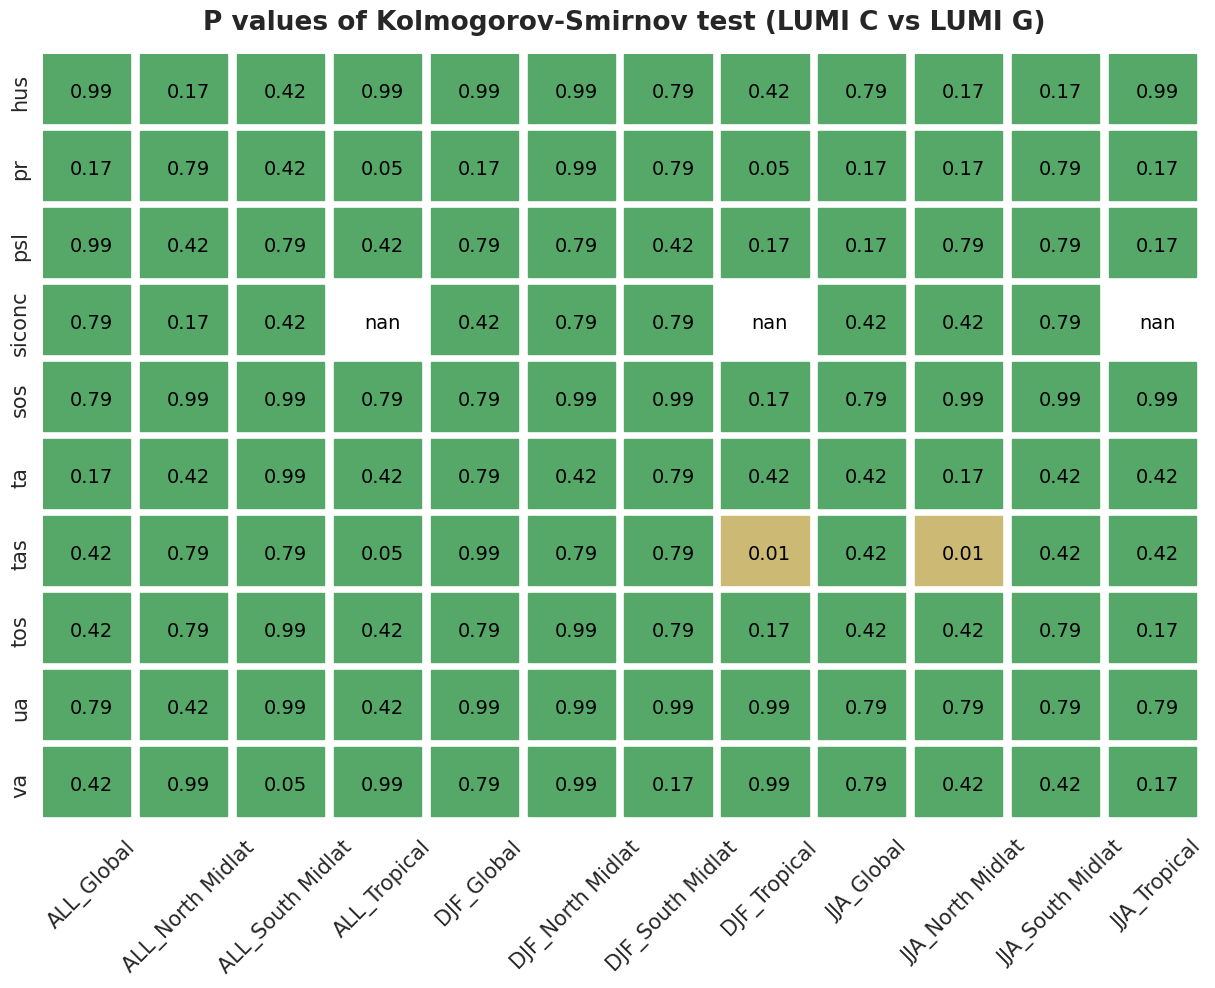

In [24]:

pi_score_dict = combine_PI_dict(machines)
pi_score_dataframe = pi_score_df(pi_score_dict)
km_test_df = km_test_score_df(pi_score_dataframe)


p_values = km_test_df.pivot_table(index="variable", columns="season",
                                  values="p_value", aggfunc='mean')

fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(p_values, cbar= False, annot=False, linewidths=15.5)


for i, row in enumerate(p_values.index):
    for j, col in enumerate(p_values.columns):
        color = km_test_df[(km_test_df['variable'] == row) & (km_test_df['season'] == col)]['color_category'].values[0]
        ax.add_patch(plt.Rectangle((j, i), 0.9, 0.9, fill=True, color=color, edgecolor='white'))
        text = "{:.2f}".format(p_values.iloc[i, j])
        ax.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black',fontsize=14)

plt.title("P values of Kolmogorov-Smirnov test (LUMI C vs LUMI G)", fontsize=19, fontweight='bold', y=1.02)
plt.xticks(fontsize=15,rotation=45)  # Adjust fontsize for x-axis ticks (columns)
plt.yticks(fontsize=15) 

ax.set_ylabel('')  # Set x-axis label with bold font
ax.set_xlabel('') 

plt.savefig("./lumi_C_G_KS_test_p_value.png", bbox_inches='tight')
